In [633]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import scipy.stats as stats
from sklearn import metrics
import statsmodels.api as sm

In [634]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [635]:
train_df=pd.read_csv('/content/drive/My Drive/Rental_Proj/train_cab.csv')
test_df=pd.read_csv('/content/drive/My Drive/Rental_Proj/test.csv')

In [636]:
train_df.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


'fare_amount' in dataset is of object datatype which needs to cleaned
and converted to float in order to use it in Algorithm.

'fare_amount' and 'passenger_count' consists of null values in the Training dataset which needs to cleaned.

In [637]:
print(train_df.shape)
print('-'*50)
print(train_df.info())
print('-'*50)
print(train_df.describe().T)
print('-'*50)
print(train_df.isnull().sum())
print('-'*50)


(16067, 7)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        16043 non-null  object 
 1   pickup_datetime    16067 non-null  object 
 2   pickup_longitude   16067 non-null  float64
 3   pickup_latitude    16067 non-null  float64
 4   dropoff_longitude  16067 non-null  float64
 5   dropoff_latitude   16067 non-null  float64
 6   passenger_count    16012 non-null  float64
dtypes: float64(5), object(2)
memory usage: 878.8+ KB
None
--------------------------------------------------
                     count       mean  ...        75%          max
pickup_longitude   16067.0 -72.462787  ... -73.966838    40.766125
pickup_latitude    16067.0  39.914725  ...  40.767381   401.083332
dropoff_longitude  16067.0 -72.462328  ... -73.963643    40.802437
dropoff_latitude   1

In [638]:
print(test_df.shape)
print('-'*50)
print(test_df.info())
print('-'*50)
print(test_df.describe().T)
print('-'*50)
print(test_df.isnull().sum())
print('-'*50)


(9914, 6)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    9914 non-null   object 
 1   pickup_longitude   9914 non-null   float64
 2   pickup_latitude    9914 non-null   float64
 3   dropoff_longitude  9914 non-null   float64
 4   dropoff_latitude   9914 non-null   float64
 5   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB
None
--------------------------------------------------
                    count       mean       std  ...        50%        75%        max
pickup_longitude   9914.0 -73.974722  0.042774  ... -73.982326 -73.968013 -72.986532
pickup_latitude    9914.0  40.751041  0.033541  ...  40.753051  40.767113  41.709555
dropoff_longitude  9914.0 -73.973657  0.039072  ... -73.980015 -73.964059 

Cleaning Of Dataset

From Google Search its evident that the latitude and longitude is of New York City Map
and the coordinates lies mostly between (40,42) and (-75,-72) respectively thereby deleting rest of outliers.

In [639]:
def coordinate_cleaning(df):
    
    df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']] = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].replace(0, np.nan)
    df = df.dropna(subset=['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude'])

    df = df.loc[df['pickup_latitude'].between(40, 42)]
    df = df.loc[df['pickup_longitude'].between(-75, -72)]
    df = df.loc[df['dropoff_latitude'].between(40, 42)]
    df = df.loc[df['dropoff_longitude'].between(-75, -72)]


    df['pickup']= df[['pickup_longitude', 'pickup_latitude']].values.tolist()
    df['dropoff']= df[['dropoff_longitude', 'dropoff_latitude']].values.tolist()
    
    return df

In [641]:
train_df = coordinate_cleaning(train_df)
test_df = coordinate_cleaning(test_df)

In [642]:
#Cleaning of fare_amount and converting it to float data type 

train_df['fare_amount'] = train_df['fare_amount'].str.extract('(\d*\.?\d*)', expand=False)
train_df['fare_amount'] = train_df['fare_amount'].str.replace(r'\s', '')

train_df['fare_amount']=train_df['fare_amount'].fillna('0')
train_df['fare_amount'] = train_df['fare_amount'].apply (pd.to_numeric)
train_df['fare_amount']= train_df['fare_amount'].replace(0, np.nan)
train_df.dropna(subset=['fare_amount'],inplace= True, axis=0)


In [643]:
#Deleting records with 'passenger_count' as nan
train_df.dropna(subset=['passenger_count'],inplace = True, axis=0)

In [644]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15641 entries, 0 to 16065
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        15641 non-null  float64
 1   pickup_datetime    15641 non-null  object 
 2   pickup_longitude   15641 non-null  float64
 3   pickup_latitude    15641 non-null  float64
 4   dropoff_longitude  15641 non-null  float64
 5   dropoff_latitude   15641 non-null  float64
 6   passenger_count    15641 non-null  float64
 7   pickup             15641 non-null  object 
 8   dropoff            15641 non-null  object 
dtypes: float64(6), object(3)
memory usage: 1.2+ MB


In [645]:
#Dropping records with 'pickup_datetime' as nan
train_df.dropna(subset=['pickup_datetime'],inplace=True,axis=0)

Feature Engineering

pickup and dropoff cordinate can be feature engineered in order to calculate the Distance travelled by Rental.
Using Geopy library to calculate the geodesic distance between two points

In [646]:
def calculateDist(cor1,cor2):
    d=geodesic(tuple(cor1),tuple(cor2)).kilometers
    
    
    return(d)

In [647]:
train_df['Distance']=train_df.apply(lambda row : calculateDist(row['pickup'], row['dropoff']), axis = 1)
test_df['Distance']=test_df.apply(lambda row : calculateDist(row['pickup'], row['dropoff']), axis = 1)


In [648]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15641 entries, 0 to 16065
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        15641 non-null  float64
 1   pickup_datetime    15641 non-null  object 
 2   pickup_longitude   15641 non-null  float64
 3   pickup_latitude    15641 non-null  float64
 4   dropoff_longitude  15641 non-null  float64
 5   dropoff_latitude   15641 non-null  float64
 6   passenger_count    15641 non-null  float64
 7   pickup             15641 non-null  object 
 8   dropoff            15641 non-null  object 
 9   Distance           15641 non-null  float64
dtypes: float64(7), object(3)
memory usage: 1.3+ MB


In [649]:
# Feature Engineering 'pickup_datetime' to extract year,month,day,weekday and hour.
def datetime_info(data):
    
    data['pickup_datetime']= data['pickup_datetime'].str.replace('UTC','')
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],errors='coerce')


    data['Year']=data['pickup_datetime'].dt.year
    data['Month']=data['pickup_datetime'].dt.month
    data['Day']=data['pickup_datetime'].dt.day
    data['Hour']=data['pickup_datetime'].dt.hour
    data['weekday'] = data.pickup_datetime.dt.weekday
    
    
    
    return data

In [650]:
train_df = datetime_info(train_df)
test_df = datetime_info(test_df)

In [651]:
#Drop all nan values in 'pickup_datetime'
train_df.dropna(subset=['pickup_datetime'],inplace=True,axis=0)

Encoding weekday,time as categorical gives the model more flexibility to apply to the linear model 

In [653]:
def get_time_labels(x):
    if x>=3 and x<=7:
        return 'EARLY_MORNING'
    elif x>=8 and x<=11:
        return 'MORNING'
    elif x>=12 and x<=17:
        return 'AFTERNOON'
    elif x>=18 and x<=22:
        return 'EVENING'
    elif x==23 or x==0 or (x>=1 and x<=2):
        return 'LATE_EVENING'
    else:
        raise ValueError('Please input values between 0 to 23')

In [654]:
def get_each_day_labels(x):
    if x>=1 and x<=7:
        return '1st_Week'
    elif x>=8 and x<=14:
        return '2nd_Week'
    elif x>=15 and x<=21:
        return '3rd_Week'
    elif x>=22 and x<=31:
        return '4th_Week'
    else:
        raise ValueError('Please input values between 0 to 31')

In [655]:
df=[train_df , test_df]
for i in df:
  
  i['Day_Time']=i.apply(lambda row:get_time_labels(row['Hour']),axis=1)
  
  i['Week_Number']=i.apply(lambda row:get_each_day_labels(row['Day']),axis=1)


In [658]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pickup_datetime    9914 non-null   datetime64[ns]
 1   pickup_longitude   9914 non-null   float64       
 2   pickup_latitude    9914 non-null   float64       
 3   dropoff_longitude  9914 non-null   float64       
 4   dropoff_latitude   9914 non-null   float64       
 5   passenger_count    9914 non-null   int64         
 6   pickup             9914 non-null   object        
 7   dropoff            9914 non-null   object        
 8   Distance           9914 non-null   float64       
 9   Year               9914 non-null   int64         
 10  Month              9914 non-null   int64         
 11  Day                9914 non-null   int64         
 12  Hour               9914 non-null   int64         
 13  weekday            9914 non-null   int64         
 14  Day_Time

Examining the Target and Dependent Variable

Its seen that Trip Fare is very unevenly Distributed with many ouliers towards 50000

Text(0.5, 1.0, 'Distribution of Trip Fare')

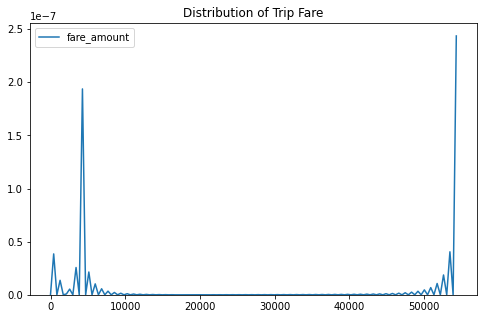

In [659]:
#Plot shows a large number of outliers
plt.figure(figsize=(8,5))
sns.kdeplot(train_df['fare_amount']).set_title("Distribution of Trip Fare")

Distance variable also has many ouliers present in the data which need to cleaned.


Text(0.5, 1.0, 'Distribution of Distance')

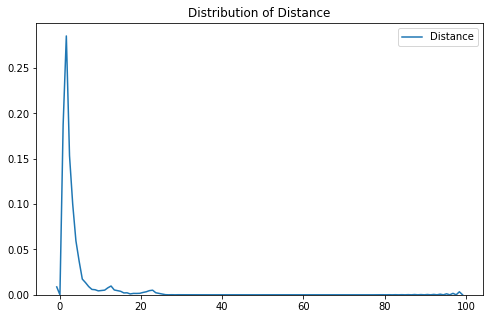

In [660]:
plt.figure(figsize=(8,5))
sns.kdeplot(train_df['Distance']).set_title("Distribution of Distance")

Text(0.5, 1.0, 'Distribution of Distance count')

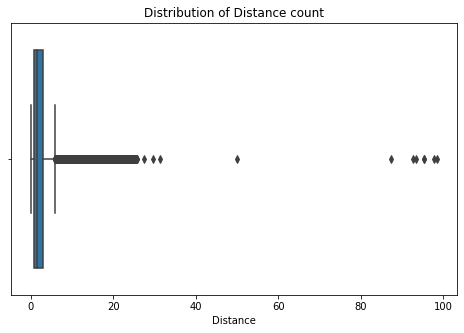

In [661]:
plt.figure(figsize=(8,5))
sns.boxplot(x = train_df['Distance']).set_title("Distribution of Distance count")

Text(0.5, 1.0, 'Distribution of Fare Amount')

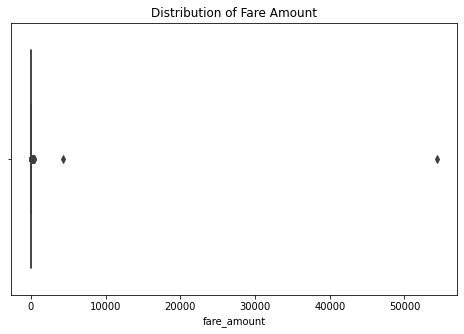

In [662]:
plt.figure(figsize=(8,5))
sns.boxplot(x = train_df['fare_amount']).set_title("Distribution of Fare Amount")

Using Zscore we detect outliers in 'fare_amount' and 'Distance' and remove them.

In [663]:
train_df.drop(train_df[abs((train_df['Distance'] - train_df['Distance'].mean())/train_df['Distance'].std(ddof=0))>3].index, inplace= True)
test_df.drop(test_df[abs((test_df['Distance'] - test_df['Distance'].mean())/test_df['Distance'].std(ddof=0))>3].index, inplace= True)

In [664]:

train_df.drop(train_df[abs((train_df['fare_amount'] - train_df['fare_amount'].mean())/train_df['fare_amount'].std(ddof=0))>3].index, inplace= True)


Text(0.5, 1.0, 'Distribution of Distance count')

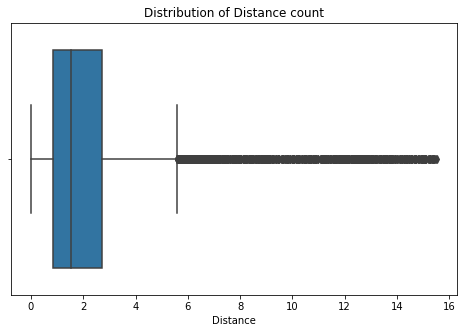

In [665]:
plt.figure(figsize=(8,5))
sns.boxplot(x = train_df['Distance']).set_title("Distribution of Distance count")

Text(0.5, 1.0, 'Distribution of Fare Amount')

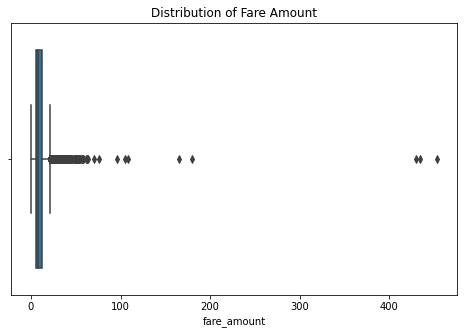

In [666]:
plt.figure(figsize=(8,5))
sns.boxplot(x = train_df['fare_amount']).set_title("Distribution of Fare Amount")

In [667]:
#Since the distance of fare amount greater than 400  is quite less and is very much inappropraite and is vedry much exceptional outlier
train_df = train_df.loc[train_df['fare_amount']< 400]

In [668]:
#It is not possible for passenger to be greater than 6
train_df = train_df.loc[train_df['passenger_count']<= 6]

Text(0, 0.5, 'Frequency')

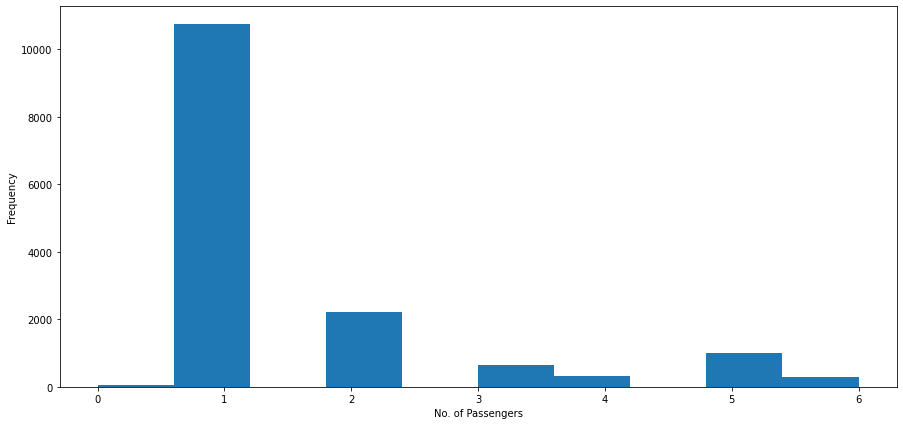

In [669]:
#Single passengers travel the most in the rentals
plt.figure(figsize=(15,7))
plt.hist(train_df['passenger_count'])
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Fare price and frequency is seen High for single passengers

Text(0, 0.5, 'Fare')

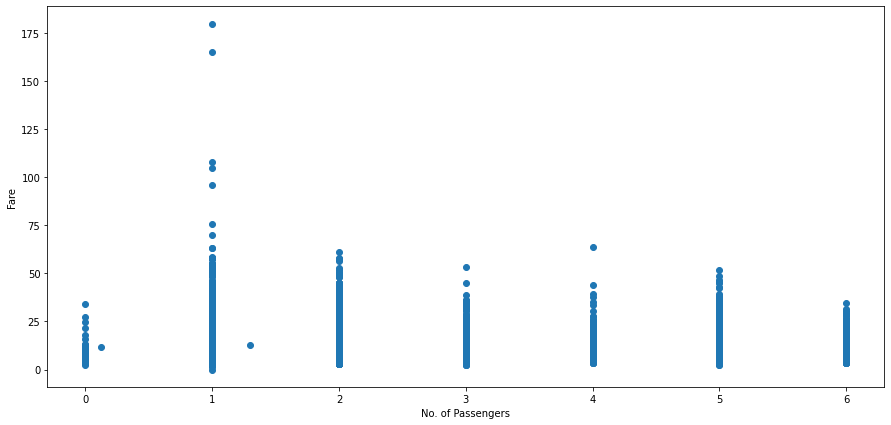

In [670]:
#Fare are seen higher for single passengers
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'])
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

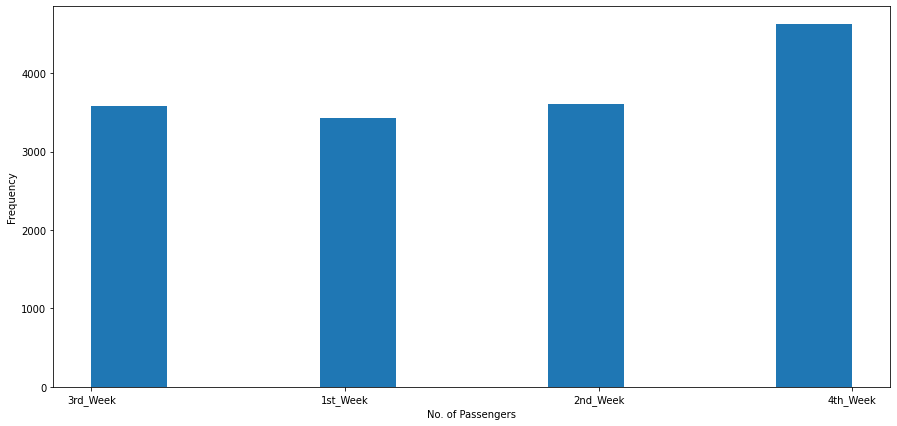

In [671]:
plt.figure(figsize=(15,7))
plt.hist(train_df['Week_Number'])
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

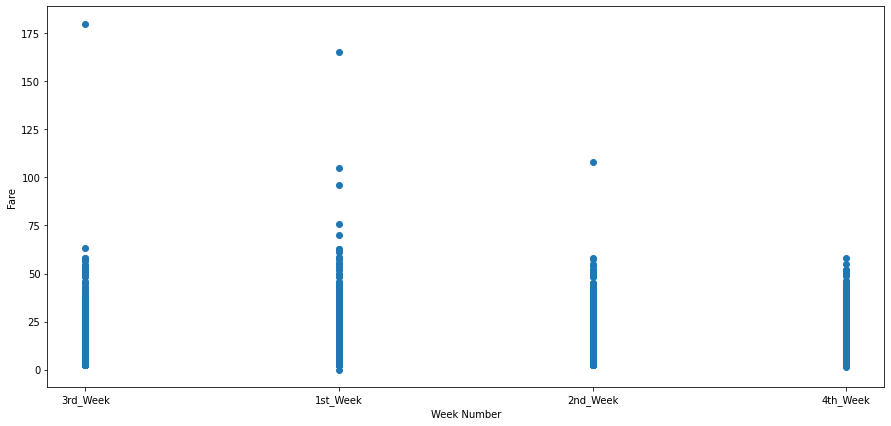

In [672]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['Week_Number'], y=train_df['fare_amount'])
plt.xlabel('Week Number')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

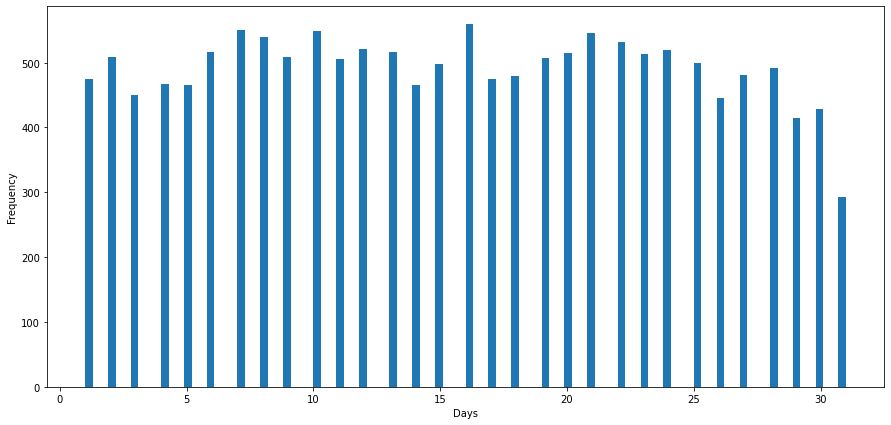

In [673]:
# Its seen that frequency is almost same throughout the month except for 31st as 31st comes only 7 times in a year
plt.figure(figsize=(15,7))
plt.hist(train_df['Day'],bins=100)
plt.xlabel('Days')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

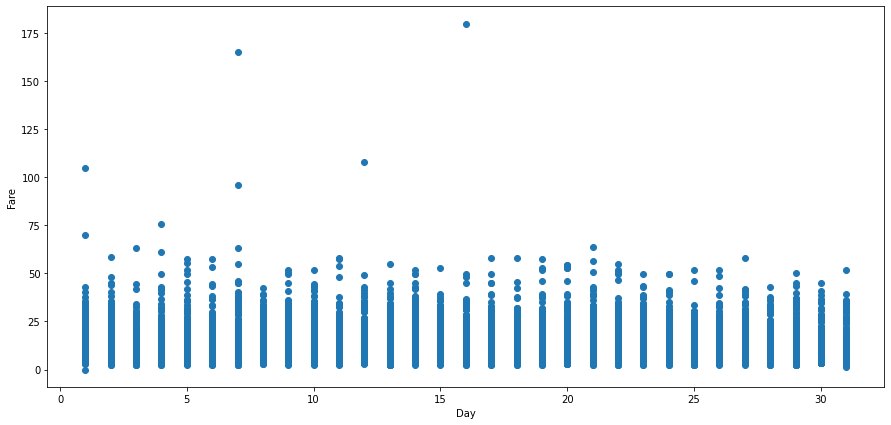

In [674]:
#fare is same throughout the month
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['Day'], y=train_df['fare_amount'])
plt.xlabel('Day')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

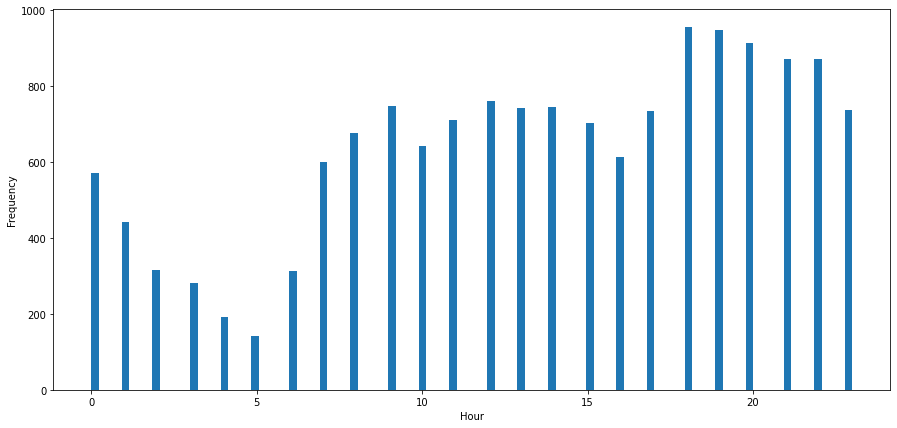

In [675]:
plt.figure(figsize=(15,7))
plt.hist(train_df['Hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

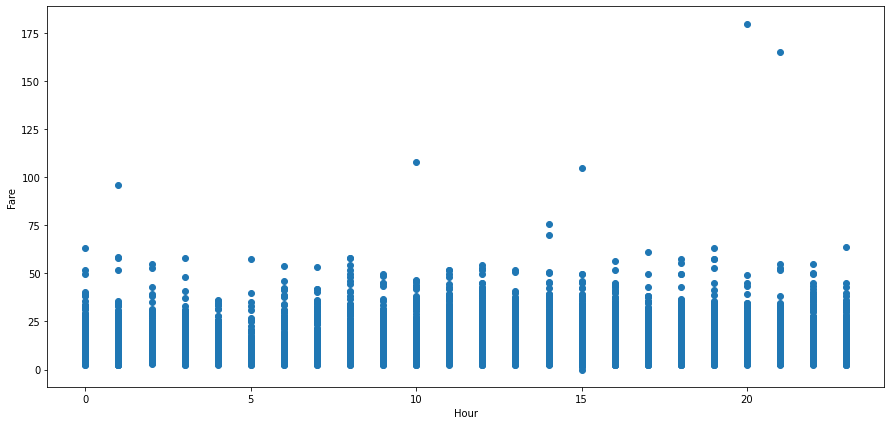

In [676]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['Hour'], y=train_df['fare_amount'])
plt.xlabel('Hour')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

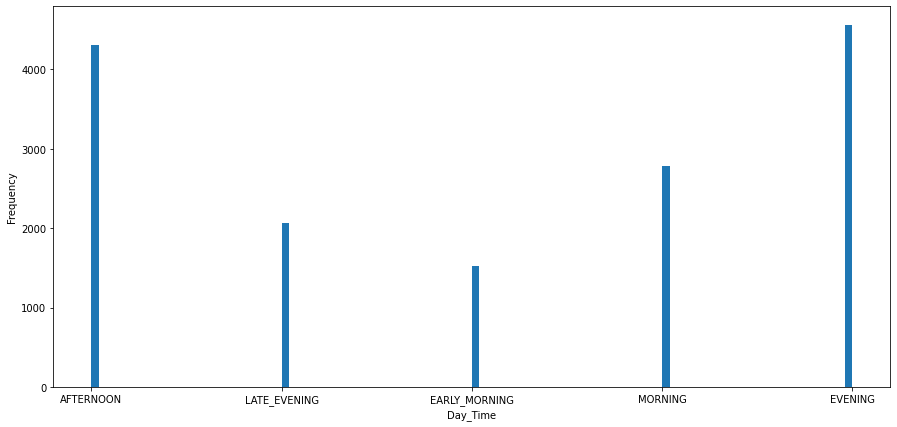

In [677]:
# the rides are more frequent in afternoon and evening
plt.figure(figsize=(15,7))
plt.hist(train_df['Day_Time'], bins=100)
plt.xlabel('Day_Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

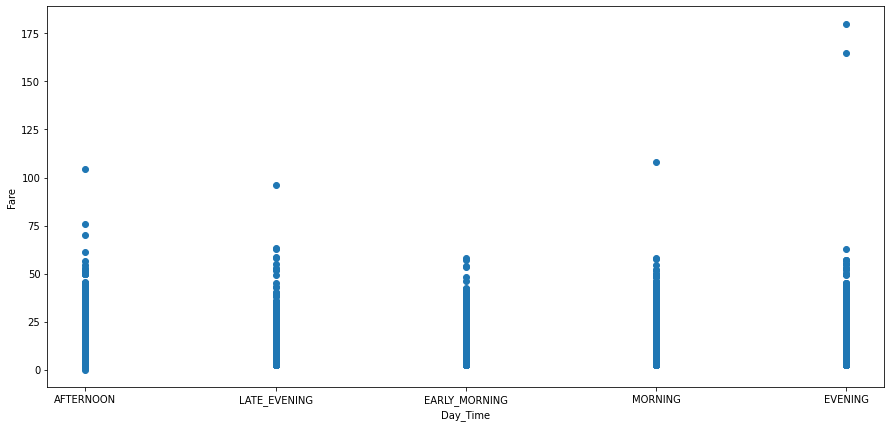

In [678]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['Day_Time'], y=train_df['fare_amount'])
plt.xlabel('Day_Time')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

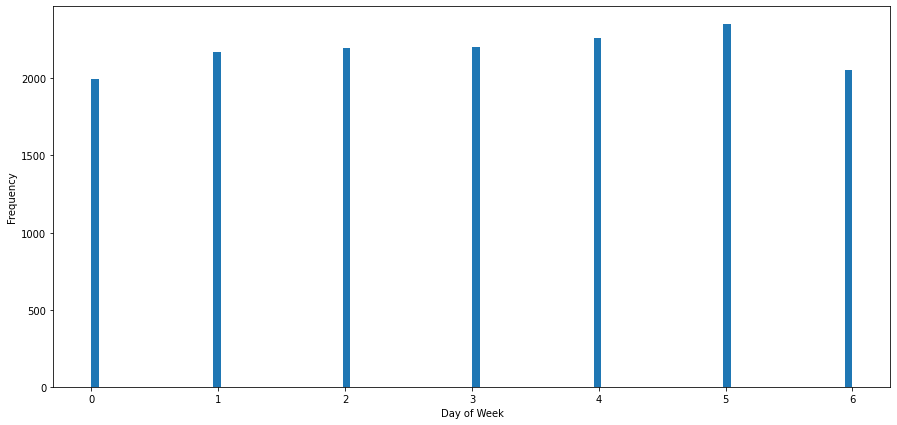

In [679]:
#Rides are higher in the weekend
plt.figure(figsize=(15,7))
plt.hist(train_df['weekday'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

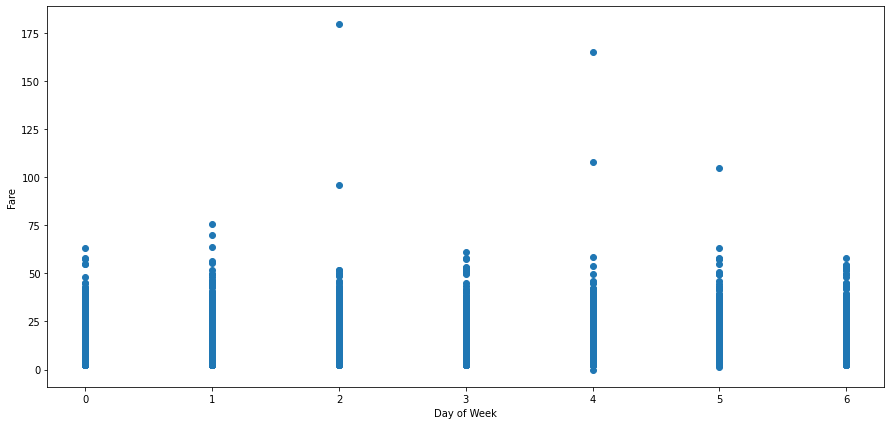

In [680]:
#The fare seems same all throughout the week
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['weekday'], y=train_df['fare_amount'])
plt.xlabel('Day of Week')
plt.ylabel('Fare')


Text(0, 0.5, 'Fare')

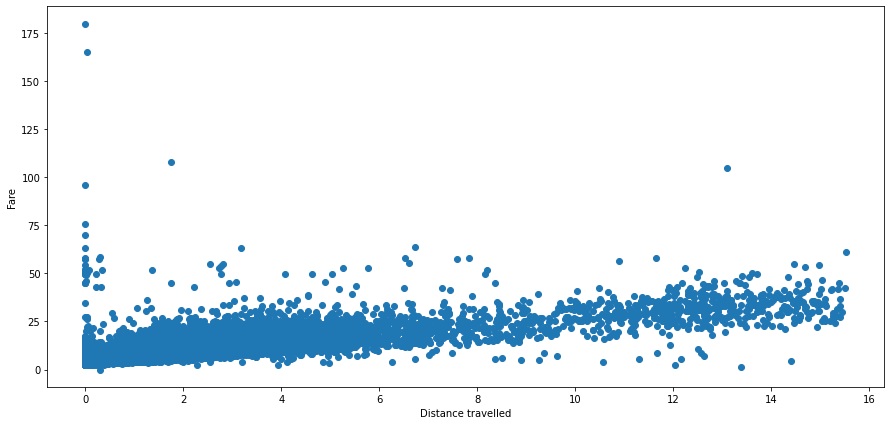

In [681]:
#the fare amount and distance is directly proportional
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['Distance'], y=train_df['fare_amount'])
plt.xlabel('Distance travelled')
plt.ylabel('Fare')

In [682]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15240 entries, 0 to 16065
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        15240 non-null  float64       
 1   pickup_datetime    15240 non-null  datetime64[ns]
 2   pickup_longitude   15240 non-null  float64       
 3   pickup_latitude    15240 non-null  float64       
 4   dropoff_longitude  15240 non-null  float64       
 5   dropoff_latitude   15240 non-null  float64       
 6   passenger_count    15240 non-null  float64       
 7   pickup             15240 non-null  object        
 8   dropoff            15240 non-null  object        
 9   Distance           15240 non-null  float64       
 10  Year               15240 non-null  float64       
 11  Month              15240 non-null  float64       
 12  Day                15240 non-null  float64       
 13  Hour               15240 non-null  float64       
 14  weekda

In [683]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup,dropoff,Distance,Year,Month,Day,Hour,weekday,Day_Time,Week_Number
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,"[-73.844311, 40.721319]","[-73.84161, 40.712278000000005]",0.412061,2009.0,6.0,15.0,17.0,0.0,AFTERNOON,3rd_Week
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,"[-74.016048, 40.711303]","[-73.979268, 40.782004]",4.646229,2010.0,1.0,5.0,16.0,1.0,AFTERNOON,1st_Week
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,"[-73.982738, 40.76127]","[-73.991242, 40.750562]",1.004797,2011.0,8.0,18.0,0.0,3.0,LATE_EVENING,3rd_Week
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,"[-73.98713000000001, 40.733143]","[-73.991567, 40.758092]",0.914154,2012.0,4.0,21.0,4.0,5.0,EARLY_MORNING,3rd_Week
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,"[-73.96809499999999, 40.768008]","[-73.956655, 40.783762]",1.366164,2010.0,3.0,9.0,7.0,1.0,EARLY_MORNING,2nd_Week


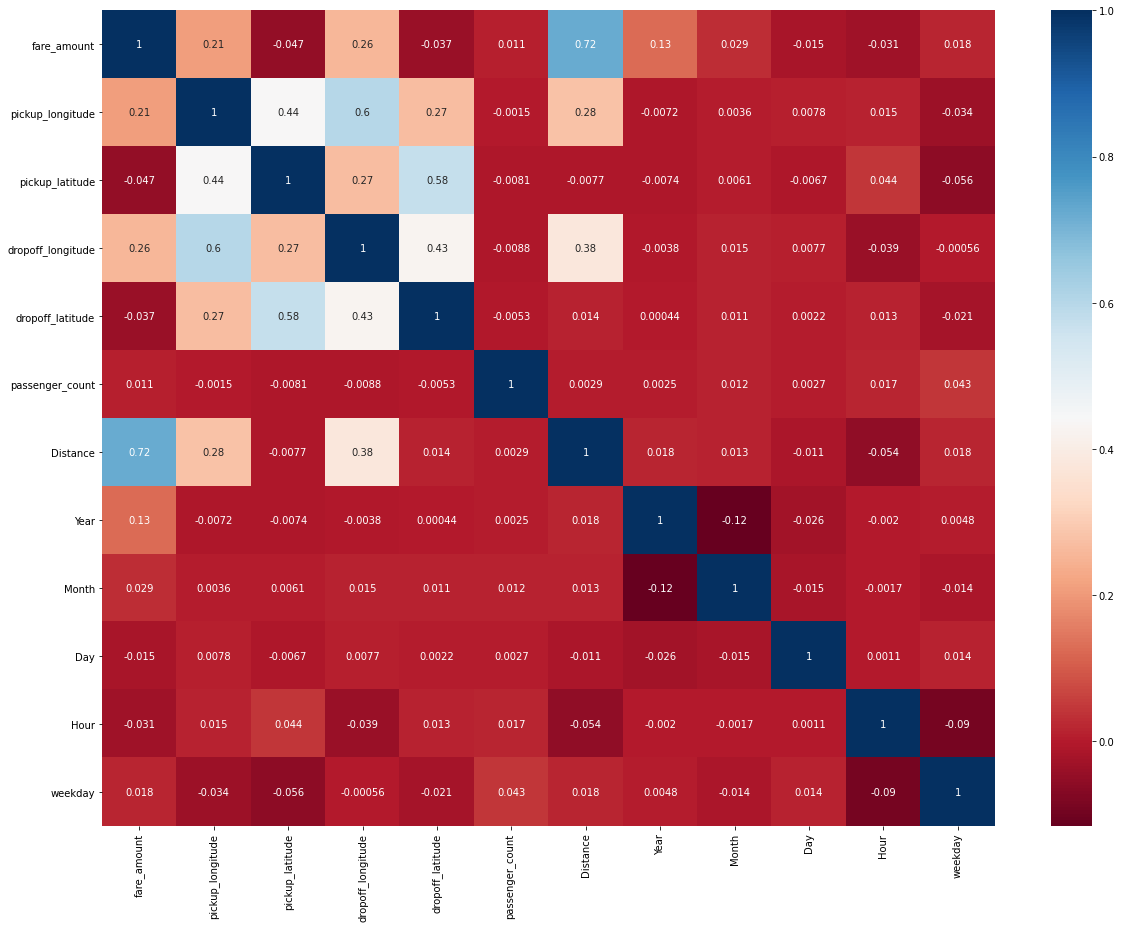

In [684]:
#The correlation matrix shows Distance having good corelation with dependent variable and other variables do not show correlation because of its categorical feature
corr = train_df.corr()
fig, axes = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr,annot= True, cmap=plt.cm.RdBu)

In [685]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15240 entries, 0 to 16065
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        15240 non-null  float64       
 1   pickup_datetime    15240 non-null  datetime64[ns]
 2   pickup_longitude   15240 non-null  float64       
 3   pickup_latitude    15240 non-null  float64       
 4   dropoff_longitude  15240 non-null  float64       
 5   dropoff_latitude   15240 non-null  float64       
 6   passenger_count    15240 non-null  float64       
 7   pickup             15240 non-null  object        
 8   dropoff            15240 non-null  object        
 9   Distance           15240 non-null  float64       
 10  Year               15240 non-null  float64       
 11  Month              15240 non-null  float64       
 12  Day                15240 non-null  float64       
 13  Hour               15240 non-null  float64       
 14  weekda

In [686]:
#Since Distance is only numerical and rest all variables to be fed to model are categorical
def diagnose(df,variable):

     
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  df[variable].hist()
    
  plt.subplot(1,2,2)
  stats.probplot(df[variable], dist='norm', plot=plt)
  plt.show()
    

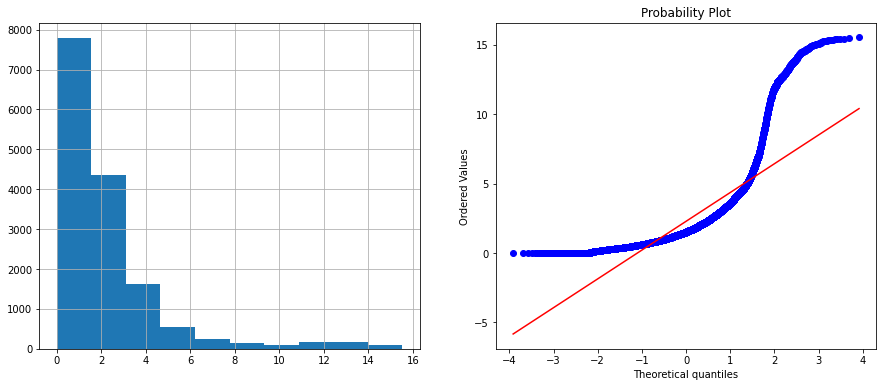

In [687]:
diagnose(train_df, 'Distance')

In [688]:
#to apply linear regression we need to normalize the dependent variables therefore we use Boxcox 
train_df['Distance'],fitted_lambda = stats.boxcox(train_df['Distance']+1)

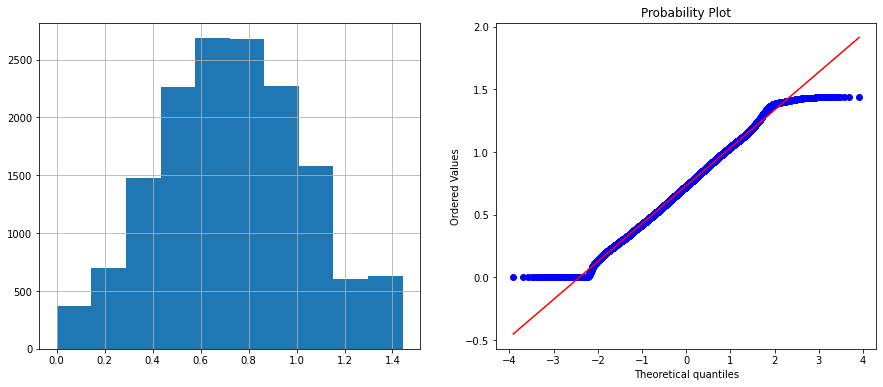

In [689]:
diagnose(train_df, 'Distance')

In [690]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup,dropoff,Distance,Year,Month,Day,Hour,weekday,Day_Time,Week_Number
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,"[-73.844311, 40.721319]","[-73.84161, 40.712278000000005]",0.314725,2009.0,6.0,15.0,17.0,0.0,AFTERNOON,3rd_Week
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,"[-74.016048, 40.711303]","[-73.979268, 40.782004]",1.123301,2010.0,1.0,5.0,16.0,1.0,AFTERNOON,1st_Week
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,"[-73.982738, 40.76127]","[-73.991242, 40.750562]",0.579540,2011.0,8.0,18.0,0.0,3.0,LATE_EVENING,3rd_Week
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,"[-73.98713000000001, 40.733143]","[-73.991567, 40.758092]",0.547395,2012.0,4.0,21.0,4.0,5.0,EARLY_MORNING,3rd_Week
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,"[-73.96809499999999, 40.768008]","[-73.956655, 40.783762]",0.688291,2010.0,3.0,9.0,7.0,1.0,EARLY_MORNING,2nd_Week


In [691]:
#One hot Encoding for datetime extracted features as becaues all unique values in these variable are not superior when compared to each other.
#In case of Month,all month should be given equal weightage.Similar explanation for other columns
def one_hot_encoding(df):

  df = pd.get_dummies(data=df, columns=['Year','Month','weekday','Day_Time','Week_Number'])

  return df

In [692]:
train_df = one_hot_encoding(train_df)
test_df = one_hot_encoding(test_df)


In [693]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15240 entries, 0 to 16065
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fare_amount             15240 non-null  float64       
 1   pickup_datetime         15240 non-null  datetime64[ns]
 2   pickup_longitude        15240 non-null  float64       
 3   pickup_latitude         15240 non-null  float64       
 4   dropoff_longitude       15240 non-null  float64       
 5   dropoff_latitude        15240 non-null  float64       
 6   passenger_count         15240 non-null  float64       
 7   pickup                  15240 non-null  object        
 8   dropoff                 15240 non-null  object        
 9   Distance                15240 non-null  float64       
 10  Day                     15240 non-null  float64       
 11  Hour                    15240 non-null  float64       
 12  Year_2009.0             15240 non-null  uint8 

Model Building

In [705]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [715]:

X_test = test_df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup', 'dropoff', 'Day', 'Hour'], axis = 1) 

In [716]:
X_train = train_df.drop(['fare_amount','pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup', 'dropoff', 'Day', 'Hour'], axis = 1) 
y_train = train_df['fare_amount'].copy()

In [717]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.3,random_state=42)


In [699]:
print(X_tr.shape)
print(X_te.shape)

(10668, 37)
(4572, 37)


In [718]:
X_with_const= sm.add_constant(X_tr)
model = sm.OLS(y_tr, X_with_const)

In [ ]:
#R square Value of 0.37 is observed.
#R squared is the coefficient of determination in which if it is close to 1,it informs model has fit very well.
#In this case r square is equivalent to 0.37 and since r square and Adj r square are very close enough, the selected features are quite relevant.
#F Statistics helps in assessing the significance of overall regression model.Since the F- statistics value is high and p value of f-statistics is 0,it tells
#there is linear relation between independent variables and target variable.
#t test shows the relationship between target variable and every predictor variable independently in which if t value is higher and p value is much lower,
#we assume the particular is of no no importance to the model.


In [701]:
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     196.5
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:04:12   Log-Likelihood:                -33971.
No. Observations:               10668   AIC:                         6.801e+04
Df Residuals:                   10635   BIC:                         6.825e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

In [719]:
X_te1 = sm.add_constant(X_te)
y_pred = result.predict(X_te1)

In [720]:
residual = y_te - y_pred


Verifying Linear Regression Assumptions


In [710]:
#the numerical variables(ie passenger_count and Distance) have very low VIF score , therefore assumption of multicollinearity hold true
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif= [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
print(vif)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[0.0, 1.0054234184479318, 1.0147548198419634, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


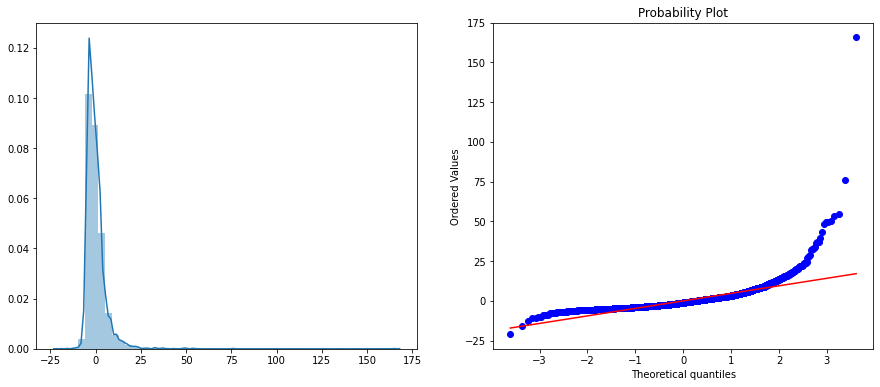

In [711]:
#Normality of Residual
#Since points are centered along 0 in distplot and most points lie in line in qq plot,Therefore it follows the assumption of normality
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(residual)
    
plt.subplot(1,2,2)
stats.probplot(residual, dist='norm', plot=plt)
plt.show()
    

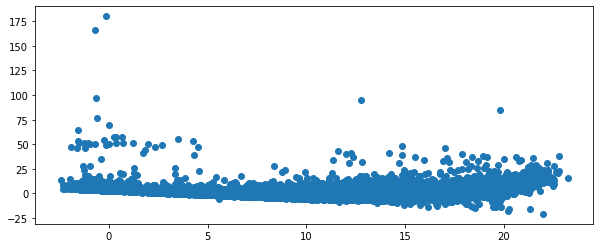

In [712]:
#Homoscaedacity
#The following scatterplot almost follows homoscaedacity as the residuals are almost equal across the regression line
fig,ax = plt.subplots(figsize=(10,4))
_=ax.scatter(y_train_pred,residuals)

In [721]:
#Same is the case with Ridge regression which gives a R square value of 0.37 and RMSE value of 5.84 which is same as Linear Regression.
#Hyper tuning the ridge model to get the fitted aplha value giving min rmse value
from sklearn.linear_model import Ridge
alphas =[1e-5,1e-3, 1e-2, 0.02, 0.04,0.08,0.1]
for alpha in alphas:

  ridge = Ridge(alpha = alpha)
  ridge.fit(X_tr, y_tr)
  y_train_pred1 = ridge.predict(X_te)

  mse = mean_absolute_error(y_te, y_train_pred1,squared= False)
  r2 = r2_score(y_te, y_train_pred1)
  print("mse",rmse)
  print('---------------------------------------------')
  print("R2_score",r2)
  print('---------------------------------------------')


print(rmse.mean())
print(r2.mean())


Rmse 5.837832658156827
---------------------------------------------
R2_score 0.3963617203079087
---------------------------------------------
Rmse 5.8378327954873805
---------------------------------------------
R2_score 0.3963616919076499
---------------------------------------------
Rmse 5.837834044105356
---------------------------------------------
R2_score 0.39636143369068844
---------------------------------------------
Rmse 5.8378354317934
---------------------------------------------
R2_score 0.3963611467136642
---------------------------------------------
Rmse 5.83783820822646
---------------------------------------------
R2_score 0.3963605725408268
---------------------------------------------
Rmse 5.837843765319805
---------------------------------------------
R2_score 0.39635942332013163
---------------------------------------------
Rmse 5.837846545979714
---------------------------------------------
R2_score 0.396358848272351
---------------------------------------------


In [722]:
#Selecting parameter for tuning in Random Forest 
grid_param = {
    'n_estimators': [50,80,100,150,175,200,250,300],
    'max_depth': [10,15,20,25,30,40]
     
}

In [723]:
rfr1 = RandomForestRegressor()

rfr_regressor= GridSearchCV(rfr1,grid_param,scoring='neg_mean_absolute_error',cv=5)
rfr_regressor.fit(X_train, y_train)
##print(rfr_regressor.best_params)
##print(rfr_regressor.best_score)
#score3=cross_val_score(rfr1,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
#score4=cross_val_score(rfr1,X_train,y_train,scoring='r2',cv=5)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [724]:
print(rfr_regressor.best_params_)
print(rfr_regressor.best_score_)

{'max_depth': 10, 'n_estimators': 200}
-2.8126336777440715


Using Cross validation

In [626]:
#Its seen that with cross validation of 10 splits the R square and mae value increases and decreases respectively

In [730]:
from sklearn.linear_model import LinearRegression
lin_reg1 = LinearRegression(n_jobs=-1,normalize = False)
#lin_reg.fit(X_train,y_train)
score1=cross_val_score(lin_reg1,X_train,y_train,scoring='neg_mean_absolute_error',cv=10)
score2=cross_val_score(lin_reg1,X_train,y_train,scoring='r2',cv=10)
print((-1*score1).mean())
print(score2.mean())

3.5482595630155154
0.3970718548565308


In [726]:
ridge = Ridge(alpha = 0.1)

score3=cross_val_score(ridge,X_train,y_train,scoring='neg_mean_absolute_error',cv=10)
score4=cross_val_score(ridge,X_train,y_train,scoring='r2',cv=10)
print((-1*score3).mean())
print(score4.mean())

3.5482154622973683
0.39707203009132325


In [729]:
rfr=RandomForestRegressor(max_depth= 10, n_estimators= 200)
score5=cross_val_score(rfr,X_train,y_train,scoring='neg_mean_absolute_error',cv=10)
score6=cross_val_score(rfr,X_train,y_train,scoring='r2',cv=10)
print((-1*score5).mean())
print(score6.mean())

2.8036639608909564
0.5582237610294297


Out of all models Random Forest Regressor is seen with maximum good fit with a r square value of 0.55 and a mean absolute error of 2.80 which is the amount of error in my measurements.It is the difference between the measured value and true value.
The smaller an MEA value, the closer predicted and observed values are.

In [731]:
final_model = RandomForestRegressor(max_depth= 10, n_estimators= 200)
pred_test_y = final_model.fit(X_train,y_train)
pred_test_y = final_model.predict(X_test)

In [732]:
test_df['fare_amount'] = pred_test_y


In [733]:
test_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup,dropoff,Distance,Day,Hour,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Day_Time_AFTERNOON,Day_Time_EARLY_MORNING,Day_Time_EVENING,Day_Time_LATE_EVENING,Day_Time_MORNING,Week_Number_1st_Week,Week_Number_2nd_Week,Week_Number_3rd_Week,Week_Number_4th_Week,fare_amount
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,"[-73.97332001, 40.76380539]","[-73.98143005, 40.74383545]",1.094593,27,13,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,22.347187
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,"[-73.98686218, 40.71938324]","[-73.99888611, 40.73920059]",1.474197,27,13,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.371515
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,"[-73.982524, 40.751259999999995]","[-73.97965400000001, 40.746139]",0.357076,8,11,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,5.646525
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,"[-73.98116, 40.767807]","[-73.990448, 40.751635]",1.150116,1,21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,16.658885
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,"[-73.96604599999999, 40.789775]","[-73.98856500000001, 40.744427]",2.875803,1,21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,43.842657


Model Evaluation with Learning Curve

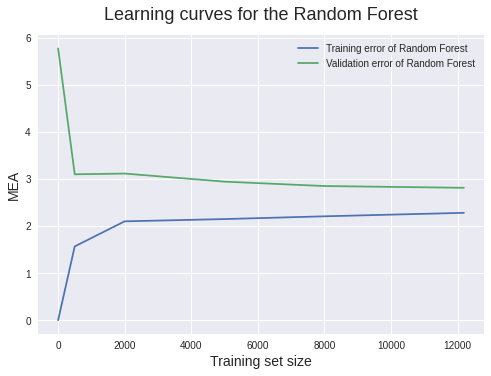

In [738]:
from sklearn.model_selection import learning_curve

train_sizes = [1, 500, 2000, 5000, 8000, 12192]
#for i in models:
   # print (model[i])
    
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = rfr,
    X = X_train,
    y = y_train, train_sizes = train_sizes, cv = 5,scoring = 'neg_mean_absolute_error')
    
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
    
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error of Random Forest')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error of Random Forest')
plt.ylabel('MEA', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for the Random Forest', fontsize = 18, y = 1.03)
plt.legend()

The error in training set increase as the error in validation set decreases. This is the case with a little high bias and low variance as the training error is little high. The Variance is estimated by examining the gap between the validation learning curve and training learning curve. A narrow gap indicates low variance